In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/tf_work


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# 犬猫画像でImageDataGenerator+finetuning試す

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batc

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 13s 804ms/step - loss: 3.6513 - accuracy: 0.5290 - val_loss: 4.6913 - val_accuracy: 0.5050
Epoch 2/5
16/16 [==============================] - 7s 442ms/step - loss: 1.6855 - accuracy: 0.5630 - val_loss: 1.4758 - val_accuracy: 0.8125
Epoch 3/5
16/16 [==============================] - 7s 451ms/step - loss: 1.1299 - accuracy: 0.6440 - val_loss: 0.4736 - val_accuracy: 0.9275
Epoch 4/5
16/16 [==============================] - 7s 449ms/step - loss: 0.7593 - accuracy: 0.7040 - val_loss: 0.2464 - val_accuracy: 0.9550
Epoch 5/5
16/16 [==============================] - 7s 433ms/step - loss: 1.0238 - accuracy: 0.6680 - val_loss: 0.5426 - val_accuracy: 0.9325


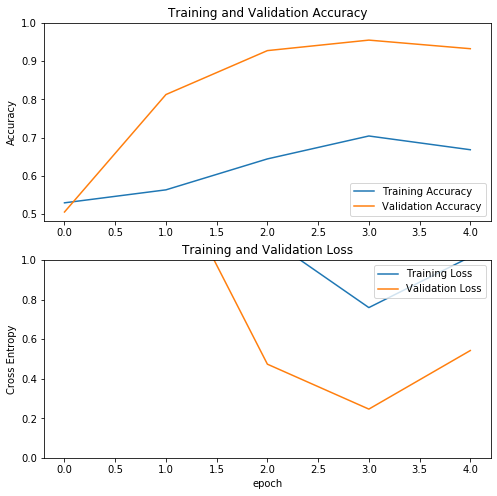

  ...
    to  
  ['...']
4/4 [==============================] - 1s 338ms/step - loss: 0.6901 - accuracy: 0.9100
0.6900628936182329 0.91


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
VALID_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
TEST_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

IMG_SIZE = 160 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64

class DataSet:

    @staticmethod
    def get_image_generator(train_IDG_options: dict):
        train_image_generator = ImageDataGenerator(**train_IDG_options) # Generator for our training data
        validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
        test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

        train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                   directory=TRAIN_DIR,
                                                                   shuffle=True,
                                                                   target_size=(IMG_SIZE, IMG_SIZE),
                                                                   class_mode='binary')

        valid_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                        directory=VALID_DIR,
                                                                        shuffle=False,
                                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                                        class_mode='binary')
        
        test_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                        directory=TEST_DIR,
                                                                        shuffle=False,
                                                                        target_size=(IMG_SIZE, IMG_SIZE),
                                                                        class_mode='binary')
        return train_data_gen, valid_data_gen, test_data_gen
    
class Model:
    
    @staticmethod
    def get_model(n_class=1):
        """モデル構築"""
        # pre-trained model
        #base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
        base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
        # finetuning
        base_model.trainable = False
        # pooling+出力層
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = tf.keras.layers.Dense(n_class)(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
        return model
            
    @staticmethod
    def train(model, train_gen, validation_gen, 
              base_learning_rate=0.01, 
              epochs=5):
        """モデルでtrain"""
        # コンパイル
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
                      metrics=['accuracy'])
        # train
        history = model.fit(train_gen,
                            epochs=epochs,
                            validation_data=validation_gen)
        
        return model, history
    
    @staticmethod
    def plot_hist(history):
        """train結果plot"""
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()
    
    
if __name__ == '__main__':
    
    train_IDG_options = {'rescale': 1.0/255.0, 
                         'width_shift_range': 0.15,
                         'height_shift_range': 0.15,
                         'horizontal_flip': True, 
                         'rotation_range': 45, 
                         'zoom_range': 0.5}
    train_data_gen, valid_data_gen, test_data_gen = DataSet().get_image_generator(train_IDG_options)

    model = Model().get_model()
    model.summary()
    trained_model, history = Model().train(model, train_data_gen, valid_data_gen)
    Model().plot_hist(history)
    
    # モデルの評価
    test_loss, test_acc = trained_model.evaluate(test_data_gen)
    print(test_loss, test_acc)


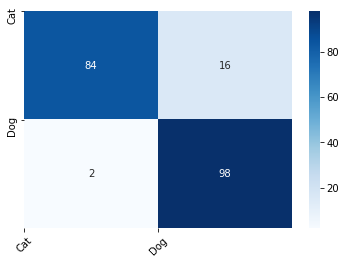

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = ["cat" if y < 0.5 else "dog" for y in test_data_gen.classes]
y_pred = ["cat" if pb < 0.5 else "dog" for pb in model.predict(test_data_gen).reshape(-1)]

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xticks(np.arange(2), ['Cat', 'Dog'], rotation=45)
plt.yticks(np.arange(2), ['Cat', 'Dog'])
plt.show()